# NLP Lab Exercise 1

**Agustinus Kristiadi / 3047084**

### Load English data

In [1]:
import numpy as np
import nltk
from nltk.corpus import treebank
from nltk.corpus import brown
from nltk.corpus import conll2000 as conll


# Conll2000
conll_tagged_sents = conll.tagged_sents()[:1000]
train_size = int(0.8 * len(conll_tagged_sents))

cn_train_sents = conll_tagged_sents[:train_size]
cn_test_sents = conll_tagged_sents[train_size:]

# Treebank
treebank_tagged_sents = treebank.tagged_sents()[:1000]
train_size = int(0.8 * len(treebank_tagged_sents))

tb_train_sents = treebank_tagged_sents[:train_size]
tb_test_sents = treebank_tagged_sents[train_size:]

# Brown
brown_tagged_sents = brown.tagged_sents()[:1000]
train_size = int(0.8 * len(brown_tagged_sents))

bn_train_sents = brown_tagged_sents[:train_size]
bn_test_sents = brown_tagged_sents[train_size:]

In [2]:
def features(sentence, index):
    return {
        'word': sentence[index],
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'prefix-1': sentence[index][0],
        'suffix-1': sentence[index][-1],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1]
    }


def untag(tagged_sentence):
    return [w for w, t in tagged_sentence]

 
def transform_to_dataset(tagged_sentences):
    W, X, y = [], [], []
    for tagged in tagged_sentences:
        for index in range(len(tagged)):
            W.append(untag(tagged)[index])
            X.append(features(untag(tagged), index))
            y.append(tagged[index][1])
 
    return W, X, y

### Model 1 - English

In [3]:
W_train_cn, X_train_cn, y_train_cn = transform_to_dataset(cn_train_sents)
W_test_cn, X_test_cn, y_test_cn = transform_to_dataset(cn_test_sents)

W_train_tb, X_train_tb, y_train_tb = transform_to_dataset(tb_train_sents)
W_test_tb, X_test_tb, y_test_tb = transform_to_dataset(tb_test_sents)

W_train_bn, X_train_bn, y_train_bn = transform_to_dataset(bn_train_sents)
W_test_bn, X_test_bn, y_test_bn = transform_to_dataset(bn_test_sents)

print(len(X_train_cn))
print(len(X_test_cn))
print()
print(len(X_train_tb))
print(len(X_test_tb))
print()
print(len(X_train_bn))
print(len(X_test_bn))

19008
4711

19933
5251

17975
4104


In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', MultinomialNB())
])

clf.fit(X_train_cn, y_train_cn)

Pipeline(memory=None,
     steps=[('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Model 2 - Pretrained

In [5]:
# nltk.download('maxent_treebank_pos_tagger')

from itertools import chain


res_tb = nltk.pos_tag(W_test_tb)
acc_tb = np.mean([x[1] == y for x, y in zip(res_tb, y_test_tb)])
print(acc_tb)

res_bn = nltk.pos_tag(W_test_bn)
acc_bn = np.mean([x[1] == y for x, y in zip(res_bn, y_test_bn)])
print(acc_bn)

0.886307370025
0.589668615984


### Model 3 - Rule Based

In [6]:
patterns = [(r'.*ing$', 'VBG'), (r'.*ed$', 'VBD'), (r'.*es$', 'VBZ'), (r'.*ould$', 'MD'), (r'.*\'s$', 'NN$'),               
             (r'.*s$', 'NNS'), (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), (r'.*', 'NN')]

# Train on conll
def_model = nltk.DefaultTagger('NN')
uni_model = nltk.UnigramTagger(cn_train_sents)
bi_model = nltk.BigramTagger(cn_train_sents)
tri_model = nltk.TrigramTagger(cn_train_sents)
regexp_model = nltk.RegexpTagger(patterns)

models = [def_model, uni_model, bi_model, tri_model, regexp_model]

# Treebank
res_tb = [m.evaluate(tb_test_sents) for m in models]
    

# Brown
res_bn = [m.evaluate(bn_test_sents) for m in models]


print(res_tb)
print(res_bn)

[0.12721386402589982, 0.6690154256332127, 0.05256141687297657, 0.036564463911635876, 0.2190059036374024]
[0.13693957115009747, 0.435916179337232, 0.02387914230019493, 0.01145224171539961, 0.2124756335282651]


## Result for Task 1

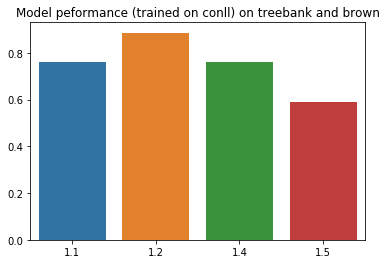

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Y = [clf.score(X_test_tb, y_test_tb), acc_tb, clf.score(X_test_tb, y_test_tb), acc_bn]

sns.barplot(['1.1', '1.2', '1.4', '1.5'], Y);
plt.title('Model peformance (trained on conll) on treebank and brown');

- ``performance 1.1`` = ``model1`` in ``X1``
- ``performance 1.2`` = ``model2`` in ``X1``    
- ``performance 1.4`` = ``model1`` in ``X2``
- ``performance 1.5`` = ``model2`` in ``X2``

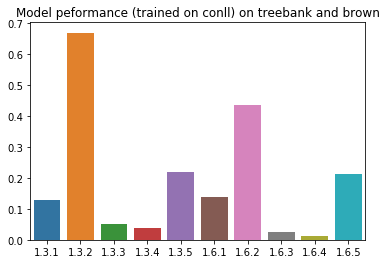

In [8]:
Y = res_tb + res_bn

sns.barplot(['1.3.1', '1.3.2', '1.3.3', '1.3.4', '1.3.5', '1.6.1', '1.6.2', '1.6.3', '1.6.4', '1.6.5'], Y);
plt.title('Model peformance (trained on conll) on treebank and brown');

- ``performance 1.3.x`` = ``model3.x`` in ``X1``
- ``performance 1.6.x`` = ``model3.x`` in ``X2``

### Model 4 - Indonesian corpus

In [9]:
with open('/Users/wiseodd/Downloads/UI-1M-tagged.txt', 'r') as f:
    tagged = []
    for line in f:
        tagged.append([nltk.tag.str2tuple(t) for t in line.split() if nltk.tag.str2tuple(t)[1] is not None])
    
id_tagged_sents = tagged[:1000]

train_size = int(0.8 * len(id_tagged_sents))

id_train_sents = id_tagged_sents[:train_size]
id_test_sents = id_tagged_sents[train_size:]

# To features
W_train_id, X_train_id, y_train_id = transform_to_dataset(id_train_sents)
W_test_id, X_test_id, y_test_id = transform_to_dataset(id_test_sents)

In [10]:
clf_id = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', MultinomialNB())
])

clf_id.fit(X_train_id, y_train_id)

Pipeline(memory=None,
     steps=[('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Model 5 - TreeTagger

In [13]:
import os
os.environ['TREETAGGER_HOME'] = "/Users/wiseodd/Downloads/TreeTagger/cmd"

from treetagger import TreeTagger


tt = TreeTagger(language='german')
res_id = tt.tag(W_test_id)

acc_id = np.mean([x[1] == y for x, y in zip(res_id, y_test_id)])

## Result for Task 2

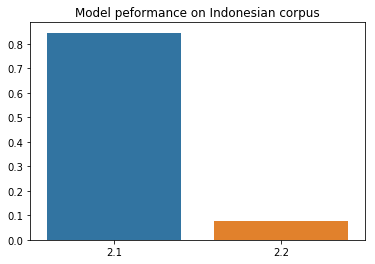

In [14]:
Y = [clf_id.score(X_test_id, y_test_id), acc_id]

sns.barplot(['2.1', '2.2'], Y);
plt.title('Model peformance on Indonesian corpus');

- ``performance 2.1`` = ``model4`` in ``X3``
- ``performance 2.2`` = ``model5`` in ``X3``